In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../../../")
from polire.interpolate import Kriging, Idw
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv("../dataset/pm.csv")

In [4]:
df = df.drop(columns=[ 'Source', 
       'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'DAILY_OBS_COUNT',
        'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC',
       'CBSA_CODE','CBSA_NAME', 'POC'
                ])

In [5]:
ladf = df[df['COUNTY']=='Los Angeles']

In [6]:
## Function for validation of dataset
def func_select_11(df):
    t = df.groupby(['Date', 'Site ID', 'STATE', 'COUNTY_CODE','COUNTY']).mean()
    t = t.reset_index(None)
    t1 = t.groupby('Site ID').count()
    t11 = t.set_index(['Site ID'])
    t11 = t11[t1['Date']>11]
    t11 = t11.reset_index(None)
    return t11

import math
def haversine(lat1, lon1, lat2, lon2): 
    """Code copied from GeeksforGeeks"""
    # distance between latitudes 
    # and longitudes 
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians 
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0

    # apply formulae 
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2)); 
    rad = 6371
    c = 2 * math.asin(math.sqrt(a)) 
    return rad * c 

def is_inside_circle(x, q, d):
    """Circle centered at $x \in \mathbb{R}^{n}$ of radius $d$. 
    Check if point q lies within the circle, or not
    """
    val = haversine( x[0], x[1], q[0], q[1])
    print(val)
    if val < d:
        return 1
    else:
        return 0

# Annual

In [7]:
from polire.interpolate import Kriging, Idw

In [8]:
la_centroids = np.load("../block_groups/la_centroids.npy")

In [9]:
la_annual = ladf.groupby('Site ID').mean()
la_annual.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)

X = la_annual[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = la_annual[['Daily Mean PM10 Concentration']]

X[:, 0] = X[:, 0] + 360
nlags = 40
k = Kriging(variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k.fit(X, y)
krig_predicted_la = k.predict(la_centroids)
idw = Idw(coordinate_type="Geographic", exponent=1)
idw.fit(X, y.values)
idw_predicted_la = idw.predict(la_centroids)

In [10]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

Text(0.5, 1.0, 'Ours - Los Angeles, CA')

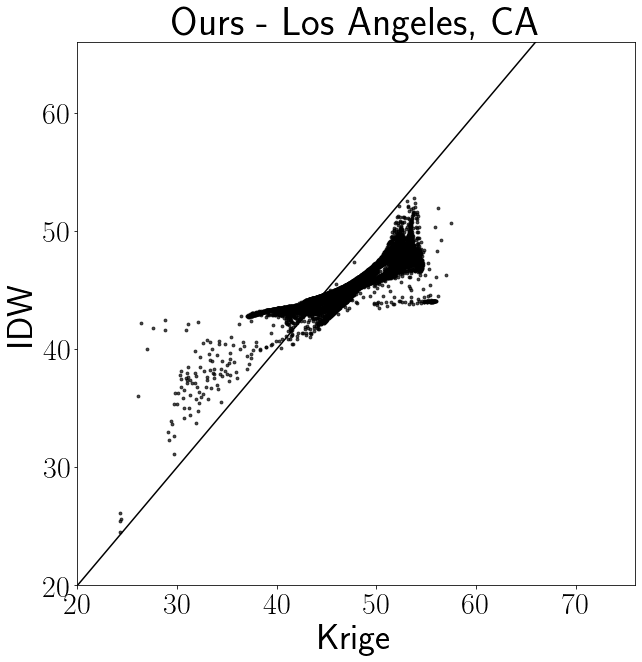

In [11]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(100)], [i for i in range(100)], color='black')
plt.scatter(krig_predicted_la, idw_predicted_la,color='black', alpha=0.7, s=8)
plt.xlim(20, 76)
plt.ylim(20, 66)
plt.xlabel("Krige", fontsize=36)
plt.ylabel("IDW", fontsize=36)
plt.tick_params(axis="both",labelsize=30)
plt.title("Ours - Los Angeles, CA", fontsize=40)

## FLORIDA

In [12]:
fldf = df[df['COUNTY']=='Duval']

In [13]:
fl_centroids = np.load("../block_groups/duval_centroids.npy")

# Annual

In [14]:

# valid_scal_4 =  func_select_11()
annual_fl = fldf.copy()
annual_fl = annual_fl.groupby('Site ID').mean()
annual_fl.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)

X = annual_fl[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = annual_fl[['Daily Mean PM10 Concentration']]

X[:, 0] = X[:, 0] + 360
nlags = 40
k = Kriging(variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k.fit(X, y)
krig_predicted_fl = k.predict(fl_centroids)
idw = Idw(coordinate_type="Geographic", exponent=1)
idw.fit(X, y.values)
idw_predicted_fl = idw.predict(fl_centroids)

Text(0.5, 1.0, 'Ours - Duval, FL')

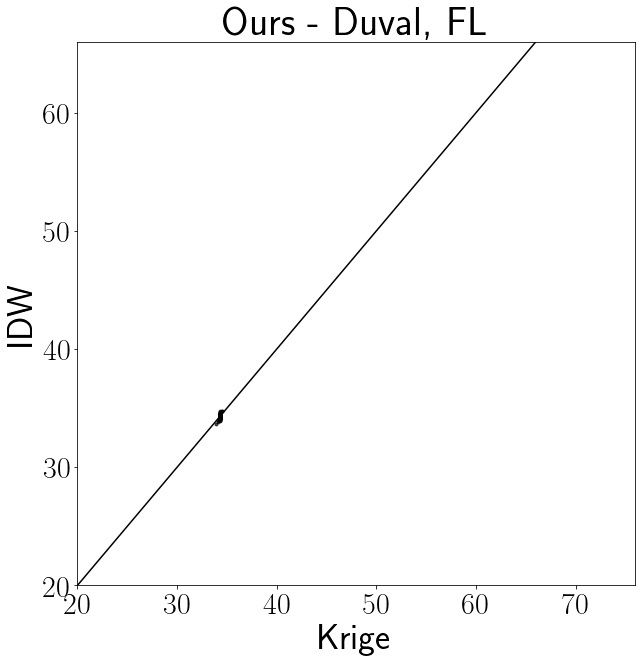

In [15]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(100)], [i for i in range(100)], color='black')
plt.scatter(krig_predicted_fl, idw_predicted_fl,color='black', alpha=0.7,s=8)
plt.xlim(20, 76)
plt.ylim(20, 66)
plt.xlabel("Krige", fontsize=36)
plt.ylabel("IDW", fontsize=36)
plt.tick_params(axis="both",labelsize=30)
plt.title("Ours - Duval, FL", fontsize=40)

## All Counties

In [16]:
states = df['STATE'].unique()
nw = ['Washington', 'Oregon', 'Wyoming','Idaho', 'Montana', 'Colorado','Utah','Nevada']
sc = ['California']
mw = ['West Virginia', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
se = ['Oklahoma','Florida', 'Alabama', 'Georgia',  'Tennessee', 'South Carolina', 'North Carolina', 'Virginia', 'Louisiana', 'Arkansas', 'Texas', 'Kentucky']
ne = ['Connecticut',
 'Delaware',
 'Maine',
 'Maryland',
 'Massachusetts',
 'New Hampshire',
 'New Jersey',
 'New York',
 'Pennsylvania',
 'Rhode Island',
 'Vermont','District Of Columbia'
]


In [17]:
nwdf = df[np.isin(df['STATE'], nw)]
mwdf = df[np.isin(df['STATE'], mw)]
sedf = df[np.isin(df['STATE'], se)]
nedf = df[np.isin(df['STATE'], ne)]
cal = df[np.isin(df['STATE'], ['California'])]
ncal = cal[cal['SITE_LATITUDE']>=34.81]
scal = cal[cal['SITE_LATITUDE']<34.81]
nwdf = pd.concat([nwdf, ncal])

In [18]:
idw_annual = []
krig_annual = []

In [19]:
def compute_idw_krig(df, centroids, nlags):
    annual = df.copy()
    annual = annual.groupby('Site ID').mean()
    annual.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace =True)
    X = annual[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
    y = annual[['Daily Mean PM10 Concentration']]
    X[:, 0] = X[:, 0] + 360
    k = Kriging(variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
    k.fit(X, y)
    krig_predicted = k.predict(centroids)
    idw = Idw(coordinate_type="Geographic", exponent=1)
    idw.fit(X, y.values)
    idw_predicted = idw.predict(centroids)
    return krig_predicted, idw_predicted

In [20]:
import geopandas as gpd

In [21]:
gdf = gpd.read_file("../block_groups/Boundary/USA_BG.shp")

In [22]:
states = scal['STATE_CODE'].unique()

In [23]:
def resize(x):
    if len(str(x))==1:
        return '0'+str(x)
    else:
        return str(x)

In [24]:
def get_centroids(gdf):
    shapes = gdf['geometry'].unique()
    centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
    centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
    centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
    centroids = np.array(centroids)
    return centroids

In [25]:
def make_gdf(df, gdf):
    states = df['STATE_CODE'].unique()
    tgdf = gdf[gdf['STATE_FIPS'].isin([resize(x) for x in states])]
    return tgdf

## Northeast -> Kriging Annual

In [26]:
ne_gdf = make_gdf(nedf, gdf)
ne_centroids = get_centroids(ne_gdf)
ne_krig, ne_idw = compute_idw_krig(nedf, ne_centroids, nlags = 40)

## Northwest -> Kriging Annual

In [27]:
nw_gdf = make_gdf(nwdf, gdf)
nw_centroids = get_centroids(nw_gdf)
nw_centroids = nw_centroids[nw_centroids[:, 1]>=34.81]
nw_krig, nw_idw = compute_idw_krig(nwdf, nw_centroids, nlags = 17)

## Southeast -> Kriging Annual

In [28]:
se_gdf = make_gdf(sedf, gdf)
se_centroids = get_centroids(se_gdf)
se_krig, se_idw = compute_idw_krig(sedf, se_centroids, nlags = 40)

## SoCal -> Kriging Annual

In [29]:
socal_gdf = make_gdf(scal, gdf)
socal_centroids = get_centroids(socal_gdf)
socal_centroids = socal_centroids[socal_centroids[:, 1]<=34.81]
socal_krig, socal_idw = compute_idw_krig(scal, socal_centroids, nlags = 17)

## MidWest -> Kriging Annual

In [30]:
mw_gdf = make_gdf(mwdf, gdf)
mw_centroids = get_centroids(mw_gdf)
mw_krig, mw_idw = compute_idw_krig(mwdf, mw_centroids, nlags = 40)

In [31]:
usa_kriging = [np.array(ne_krig), np.array(nw_krig), np.array(se_krig), np.array(socal_krig), np.array(mw_krig)]
usa_idw = [ne_idw.reshape(-1,), nw_idw.reshape(-1,), se_idw.reshape(-1,), socal_idw.reshape(-1,), mw_idw.reshape(-1,)]

In [32]:
usa_kriging[0].shape, usa_kriging[1].shape

((47163,), (26995,))

In [33]:
usa_kriging_final = usa_kriging[0]
for i in range(1, 5):
    usa_kriging_final = np.append(usa_kriging_final, usa_kriging[i])

In [34]:
usa_idw_final = usa_idw[0]
for i in range(1, 5):
    usa_idw_final = np.append(usa_idw_final, usa_idw[i])

Text(0.5, 1.0, 'Ours - All counties in the USA')

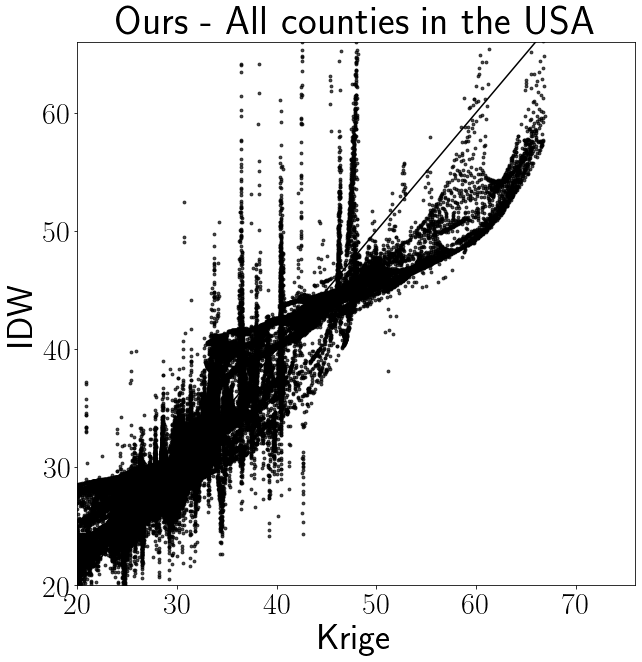

In [35]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(100)], [i for i in range(100)], color='black')
plt.scatter(usa_kriging_final, usa_idw_final,color='black', alpha=0.7,s=8)
plt.xlim(20, 76)
plt.ylim(20, 66)
plt.xlabel("Krige", fontsize=36)
plt.ylabel("IDW", fontsize=36)
plt.tick_params(axis="both",labelsize=30)
plt.title("Ours - All counties in the USA", fontsize=40)